References

https://www.tensorflow.org/tutorials/structured_data/preprocessing_layers

In [555]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
import seaborn as sns
from datetime import datetime

In [556]:
data = pd.read_csv('input_file_2.csv', sep = ',', index_col=0)

In [557]:
data['issue_d'] = pd.to_datetime(data['issue_d'])

In [558]:
print(data.shape)

(814643, 21)


In [559]:
'''Exclude the period from the beginning of 2016 onward as it is noticed in time-series plots that this period has
 a significant portion of the expected defaults not reported yet. This would hence be biased.'''

data = data.loc[data['issue_d'] < '2016-1-1']

In [560]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 646878 entries, 0 to 992899
Data columns (total 21 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   loan_amnt             646878 non-null  float64       
 1   term                  646878 non-null  int64         
 2   installment           646878 non-null  float64       
 3   emp_length            615380 non-null  float64       
 4   home_ownership        646878 non-null  object        
 5   verification_status   646878 non-null  object        
 6   issue_d               646878 non-null  datetime64[ns]
 7   purpose               646878 non-null  object        
 8   dti                   646878 non-null  float64       
 9   earliest_cr_line      646878 non-null  int64         
 10  open_acc              646878 non-null  float64       
 11  pub_rec               646878 non-null  float64       
 12  revol_util            646507 non-null  float64       
 13 

In [561]:
data['charged_off'].value_counts()

0    516026
1    130852
Name: charged_off, dtype: int64

<AxesSubplot:>

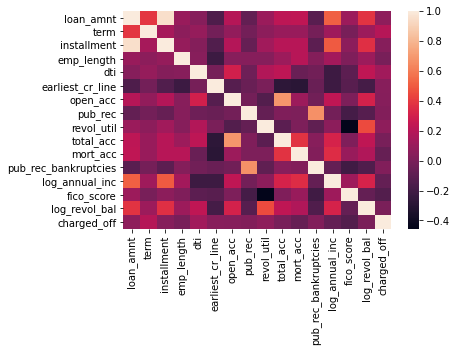

In [562]:
corr = data.corr()

sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values)

In [563]:
train_df = data.loc[data['issue_d'] < data['issue_d'].quantile(0.90)]
test_df = data.loc[data['issue_d'] >= data['issue_d'].quantile(0.90)]

In [564]:
train_df.drop('issue_d', axis=1, inplace=True)
test_df.drop('issue_d', axis=1, inplace=True)

c:\Users\joshy\anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [565]:
all_cols = list(train_df.columns)

print('to scale     ', all_cols)

print(len(all_cols))

all_cols.remove('charged_off')


to scale      ['loan_amnt', 'term', 'installment', 'emp_length', 'home_ownership', 'verification_status', 'purpose', 'dti', 'earliest_cr_line', 'open_acc', 'pub_rec', 'revol_util', 'total_acc', 'application_type', 'mort_acc', 'pub_rec_bankruptcies', 'log_annual_inc', 'fico_score', 'log_revol_bal', 'charged_off']
20


In [566]:
to_drop_categorical = ['home_ownership', 'verification_status', 'purpose', 'application_type']

In [567]:
for i in to_drop_categorical:

    all_cols.remove(i)

print('to scale     ', all_cols)

print(len(all_cols))


to scale      ['loan_amnt', 'term', 'installment', 'emp_length', 'dti', 'earliest_cr_line', 'open_acc', 'pub_rec', 'revol_util', 'total_acc', 'mort_acc', 'pub_rec_bankruptcies', 'log_annual_inc', 'fico_score', 'log_revol_bal']
15


In [568]:
data.isna().sum()

loan_amnt                   0
term                        0
installment                 0
emp_length              31498
home_ownership              0
verification_status         0
issue_d                     0
purpose                     0
dti                         0
earliest_cr_line            0
open_acc                    0
pub_rec                     0
revol_util                371
total_acc                   0
application_type            0
mort_acc                47179
pub_rec_bankruptcies      694
log_annual_inc              0
fico_score                  0
log_revol_bal               0
charged_off                 0
dtype: int64

In [569]:
# Similar to SimpleImputer  

train_df[all_cols] = train_df[all_cols].fillna(train_df[all_cols].mean())
test_df[all_cols] = test_df[all_cols].fillna(train_df[all_cols].mean())
print('null values      ', train_df.isnull().sum())
print(type(train_df))

null values       loan_amnt               0
term                    0
installment             0
emp_length              0
home_ownership          0
verification_status     0
purpose                 0
dti                     0
earliest_cr_line        0
open_acc                0
pub_rec                 0
revol_util              0
total_acc               0
application_type        0
mort_acc                0
pub_rec_bankruptcies    0
log_annual_inc          0
fico_score              0
log_revol_bal           0
charged_off             0
dtype: int64
<class 'pandas.core.frame.DataFrame'>


c:\Users\joshy\anaconda3\lib\site-packages\pandas\core\frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [570]:
# Same process as StandardScaler

def get_normalization_layer(name, dataset):
  # Create a Normalization layer for the feature.
  normalizer = layers.Normalization(axis=None)

  # Prepare a Dataset that only yields the feature.
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the statistics of the data.
  normalizer.adapt(feature_ds)

  return normalizer

In [571]:
def get_category_encoding_layer(name, dataset, dtype, max_tokens=None):
  # Create a layer that turns strings into integer indices.
  if dtype == 'string':
    index = layers.StringLookup()
  # Otherwise, create a layer that turns integer values into integer indices.
  else:
    index = layers.IntegerLookup()

  # Prepare a `tf.data.Dataset` that only yields the feature.
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the set of possible values and assign them a fixed integer index.
  index.adapt(feature_ds)

  # Encode the integer indices.
  encoder = layers.CategoryEncoding(num_tokens=index.vocabulary_size())

  # Apply multi-hot encoding to the indices. The lambda function captures the
  # layer, so you can use them, or include them in the Keras Functional model later.
  return lambda feature: encoder(index(feature))

In [572]:
# Need to check the model accuracy with and without balancing classes

'''Split by label categories to downsample and provide balanced classes for training.'''

train_dat_1s = train_df[train_df['charged_off'] == 1]

train_dat_0s = train_df[train_df['charged_off'] == 0]

keep_0s = train_dat_0s.sample(frac=train_dat_1s.shape[0]/train_dat_0s.shape[0])

train_df = pd.concat([keep_0s,train_dat_1s],axis=0)

In [573]:
'''Split by label categories to downsample and provide balanced classes for testing (to have a meaningful AUC score as well).'''

test_dat_1s = test_df[test_df['charged_off'] == 1]

test_dat_0s = test_df[test_df['charged_off'] == 0]

keep_0s = test_dat_0s.sample(frac=test_dat_1s.shape[0]/test_dat_0s.shape[0])

test_df = pd.concat([keep_0s,test_dat_1s],axis=0)

In [574]:
'''rep_1 =[train_dat_1s for x in range(train_dat_0s.shape[0]//train_dat_1s.shape[0] )]
keep_1s = pd.concat(rep_1, axis=0)
train_df = pd.concat([keep_1s,train_dat_0s],axis=0)'''

'''Check for test and training shapes and value counts'''

print(train_dat_1s.shape[0]/train_dat_0s.shape[0], train_dat_1s.shape[0], train_dat_0s.shape[0])

print('train and test shape     ', train_df.shape, test_df.shape)

print('value counts train     ', train_df['charged_off'].value_counts())

print('value counts test     ', test_df['charged_off'].value_counts())


0.2411275717144331 111705 463261
train and test shape      (223410, 20) (38294, 20)
value counts train      0    111705
1    111705
Name: charged_off, dtype: int64
value counts test      0    19147
1    19147
Name: charged_off, dtype: int64


In [575]:
# Test the impact on the model when including repeat, prefetch and shuffle buffer

def easy_input_function(df, label_key, shuffle, batch_size):
  label = df[label_key]
  
  ds = tf.data.Dataset.from_tensor_slices((dict(df),label))

  if shuffle:
    ds = ds.shuffle(10000)

  # Split into batches for quicker training and computing resources
  ds = ds.batch(batch_size)

  return ds

In [576]:
train_ds = easy_input_function(train_df, label_key='charged_off', shuffle=False, batch_size=20000)
test_ds = easy_input_function(test_df, label_key='charged_off', shuffle=False, batch_size=200000)

In [577]:
# [(train_features, label_batch)] = train_ds.take(1)
# print('Every feature:', list(train_features.keys()))
# print('A batch of loan amounts:', train_features['loan_amnt'])
# print('A batch of targets:', label_batch )

In [578]:
all_inputs = []
encoded_features = []

# Numerical features.
for header in all_cols:
  numeric_col = tf.keras.Input(shape=(1,), name=header)
  normalization_layer = get_normalization_layer(header, train_ds)
  encoded_numeric_col = normalization_layer(numeric_col)
  all_inputs.append(numeric_col)
  encoded_features.append(encoded_numeric_col)

In [579]:
for header in to_drop_categorical:
  categorical_col = tf.keras.Input(shape=(1,), name=header, dtype='string')
  encoding_layer = get_category_encoding_layer(name=header,
                                               dataset=train_ds,
                                               dtype='string',
                                               )
  encoded_categorical_col = encoding_layer(categorical_col)
  all_inputs.append(categorical_col)
  encoded_features.append(encoded_categorical_col)

In [580]:
# print(type(train_df.iloc[0]['home_ownership']))

# for header in to_drop_categorical:

#     print(train_df[header].value_counts())

In [581]:
all_features = tf.keras.layers.concatenate(encoded_features)
# 19 features
layer1 = tf.keras.layers.Dense(5, input_dim=19, activation="tanh")(all_features)
d1 = tf.keras.layers.Dropout(0.2)(layer1)
layer2 = tf.keras.layers.Dense(5, input_dim=5, activation="tanh")(d1)
d2 = tf.keras.layers.Dropout(0.2)(layer2)
output = tf.keras.layers.Dense(1, activation="sigmoid")(d2)

model = tf.keras.Model(all_inputs, output)

In [582]:
model.compile(optimizer='adam',
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                metrics=[ tf.keras.metrics.AUC(from_logits=False), tf.keras.metrics.TruePositives(),tf.keras.metrics.FalseNegatives(), tf.keras.metrics.FalsePositives(), tf.keras.metrics.TrueNegatives()])

In [583]:
now = datetime.now()
dt_string = now.strftime("%d-%m-%Y %H-%M-%S")

In [584]:
history = model.fit(train_ds, epochs=20)

Epoch 1/10


C:\Users\joshy\AppData\Roaming\Python\Python38\site-packages\keras\engine\functional.py:582: UserWarning: Input dict contained keys ['charged_off'] which did not match any model input. They will be ignored by the model.
  warnings.warn(


12/12 [==============================] - 4s 228ms/step - loss: 0.6934 - auc_62: 0.5231 - true_positives_2: 53307.0000 - false_negatives_6: 58398.0000 - false_positives_1: 49772.0000 - true_negatives_1: 61933.0000
Epoch 2/10
12/12 [==============================] - 3s 210ms/step - loss: 0.6884 - auc_62: 0.5557 - true_positives_2: 54907.0000 - false_negatives_6: 56798.0000 - false_positives_1: 46023.0000 - true_negatives_1: 65682.0000
Epoch 3/10
12/12 [==============================] - 3s 215ms/step - loss: 0.6859 - auc_62: 0.5708 - true_positives_2: 57193.0000 - false_negatives_6: 54512.0000 - false_positives_1: 45710.0000 - true_negatives_1: 65995.0000
Epoch 4/10
12/12 [==============================] - 3s 211ms/step - loss: 0.6839 - auc_62: 0.5814 - true_positives_2: 59287.0000 - false_negatives_6: 52418.0000 - false_positives_1: 46547.0000 - true_negatives_1: 65158.0000
Epoch 5/10
12/12 [==============================] - 3s 211ms/step - loss: 0.6813 - auc_62: 0.5950 - true_positives_

In [585]:
print(model.summary())

Model: "model_36"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
home_ownership (InputLayer)     [(None, 1)]          0                                            
__________________________________________________________________________________________________
verification_status (InputLayer [(None, 1)]          0                                            
__________________________________________________________________________________________________
purpose (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
application_type (InputLayer)   [(None, 1)]          0                                            
___________________________________________________________________________________________

In [586]:
loss, auc, TP, FN, FP, TN = model.evaluate(test_ds)

1/1 [==============================] - 1s 1s/step - loss: 0.6666 - auc_62: 0.6577 - true_positives_2: 13140.0000 - false_negatives_6: 6007.0000 - false_positives_1: 8845.0000 - true_negatives_1: 10302.0000


ValueError: too many values to unpack (expected 2)

In [ ]:
filename = 'Results %s.txt' % (dt_string)


with open(filename, 'w') as f:
    f.write("Model Built at ")
    f.write("%s\n" % dt_string)
    f.write("%s\n" % "Model Architecture")
    f.write("%s\n" % model.to_json(indent=4))
    f.write("%s\n" % "Training AUC")
    for score in history.history[r'auc_51']:
        f.write("%s\n" % score)
    f.write("%s\n" % "Test AUC")
    f.write("%s\n" % str(accuracy))
    f.close()


In [ ]:
history.history

{'loss': [0.7277415990829468,
  0.6566569805145264,
  0.60722416639328,
  0.5672823190689087,
  0.5365262031555176,
  0.5152217745780945,
  0.502379298210144,
  0.49490824341773987,
  0.4894394278526306,
  0.48572883009910583],
 'auc_51': [0.5205937623977661,
  0.5312424898147583,
  0.5388539433479309,
  0.5499387383460999,
  0.5603171586990356,
  0.5709543228149414,
  0.5822528004646301,
  0.5937248468399048,
  0.6062352657318115,
  0.6160184741020203]}